In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu as mw
import scipy
from scipy import stats

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
SEX: пол клиента (1 = мужской, 2 = женский )
EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
AGE: возраст в годах
PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
default - индикатор невозврата денежных средств

In [2]:
data = pd.read_csv("credit_card_default_analysis.csv")

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
no_default = data[data.default == 0]
default = data[data.default == 1]

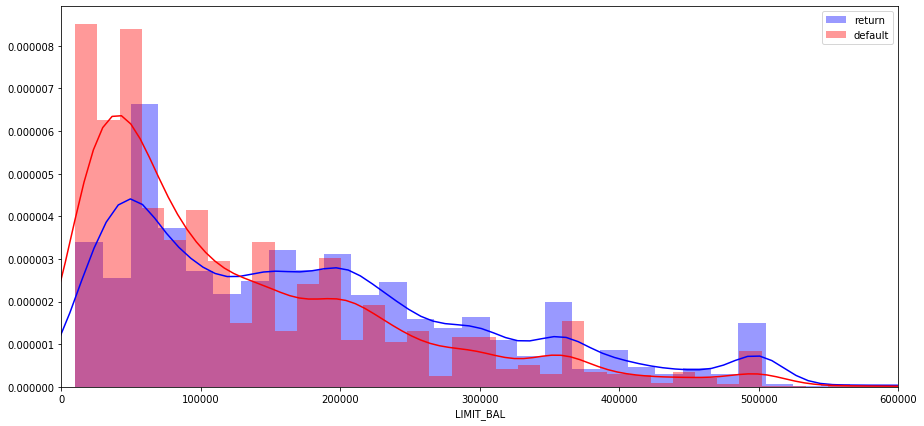

In [5]:
plt.figure(figsize = (15, 7))
sns.distplot(no_default['LIMIT_BAL'], color = 'blue', label = 'return')
sns.distplot(default['LIMIT_BAL'], color = 'red', label = 'default')
plt.legend()
plt.xlim(0, 600000)
plt.show()

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

## bootstrap

In [6]:
no_default.LIMIT_BAL.median()

150000.0

In [7]:
default.LIMIT_BAL.median()

90000.0

In [8]:
def bootstrap(data, n):
    ind = np.random.randint(0, len(data), (n, len(data)))
    return data[ind]

In [9]:
def percentile(stat, alpha = 0.05):
    return np.percentile(stat, [alpha/2 * 100, (1 - alpha/2) * 100])

In [10]:
no_def_med = np.median(bootstrap(no_default.LIMIT_BAL.values, 1000), axis = 1)
print("95% confidence interval (default = 0)", percentile(no_def_med))
def_med = np.median(bootstrap(default.LIMIT_BAL.values, 1000), axis = 1)
print("95% confidence interval (default = 1)", percentile(def_med))

95% confidence interval (default = 0) [150000. 150000.]
95% confidence interval (default = 1) [80000. 90000.]


In [11]:
diff_med = [x[0] - x[1] for x in zip(no_def_med, def_med)]
print("95% confidence interval difference median", percentile(diff_med))

95% confidence interval difference median [60000. 70000.]


In [12]:
print ('Уровень значимости критерия Манна-Уитни:',
       mw(no_default.LIMIT_BAL.values, default.LIMIT_BAL.values, alternative = 'two-sided')[1])

Уровень значимости критерия Манна-Уитни: 1.2255485818223303e-189


Гипотеза о равенстве распределений для независимых выборок уверенно отвергается ранговым критерием Манна-Уитни на уровне значимости 0.05.

## Перестановочный критерий

In [13]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [14]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [15]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [16]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [17]:
permutation_test(no_default['LIMIT_BAL'].values, default['LIMIT_BAL'].values, 10000)

0.0001

Нулевая гипотеза о равенстве распределений на уровне значимости 0.05 отвергается в пользу альтернативной

# Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

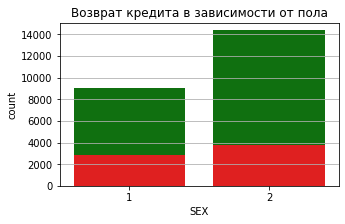

In [18]:
plt.figure(figsize = (5, 3))
plt.grid()
plt.title("Возврат кредита в зависимости от пола")
sns.countplot(x = no_default['SEX'], color = 'green')
sns.countplot(x = default['SEX'], color = 'red')
plt.show()

In [19]:
table = data.pivot_table(index = 'default', values = 'LIMIT_BAL', columns = 'SEX',
                         aggfunc = len, fill_value = 0)

In [20]:
table

SEX,1,2
default,,
0,9015,14349
1,2873,3763


In [21]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [22]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [23]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
men = list(data[data.SEX == 1].default)
women = list(data[data.SEX == 2].default)

In [25]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(men, women))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


In [26]:
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(men, women)))

p-value: 4.472866521609831e-12


In [27]:
sex_no_def = data[data.default == 0].SEX
sex_def = data[data.default == 1].SEX

In [28]:
list_1 = [0 if x == 2 else x for x in sex_no_def]
list_2 = [0 if x == 2 else x for x in sex_def]
print("95% confidence interval for a difference between proportions:\n", 
      proportions_diff_confint_ind(list_1, list_2, alpha = 0.05))

95% confidence interval for a difference between proportions:
 (-0.060548077974896725, -0.03363493274962867)


In [29]:
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(list_1, list_2)))

p-value: 4.472866521609831e-12


Доля мужчин в группе вернувших кредит клиентов больше, чем доля в группе не вернувших.
Нулевая гипотеза о равенстве распределений на уровне значимости 0.05 отвергается в пользу альтернативной

# Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

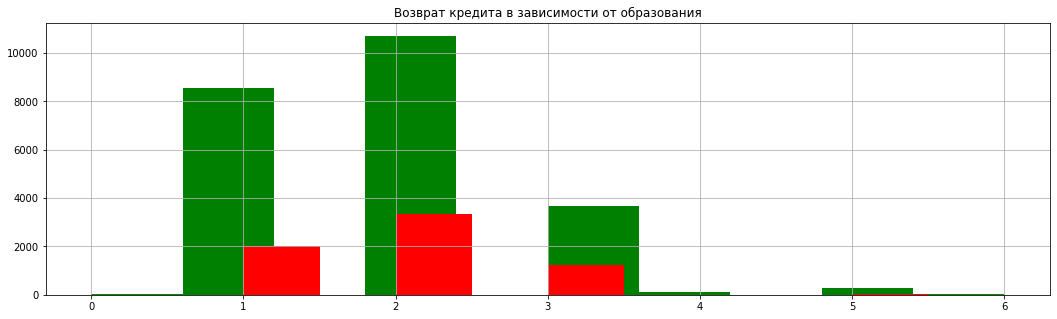

In [30]:
plt.figure(figsize = (18, 5))
plt.title("Возврат кредита в зависимости от образования")
plt.hist(x = no_default['EDUCATION'].values, color = 'green')
plt.hist(x = default['EDUCATION'].values, color = 'red')
plt.grid()
plt.show()

In [31]:
table = data.pivot_table(index = 'default', values = 'LIMIT_BAL', columns = 'EDUCATION', 
                        aggfunc = len, fill_value = 0)

In [32]:
table.columns = ['доктор', 'магистр', 'бакалавр','выпускник школы', 'начальное образование',
            'прочее', 'нет данных']

In [33]:
table

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [34]:
edu = table.div(table.sum(axis = 0), axis = 1)

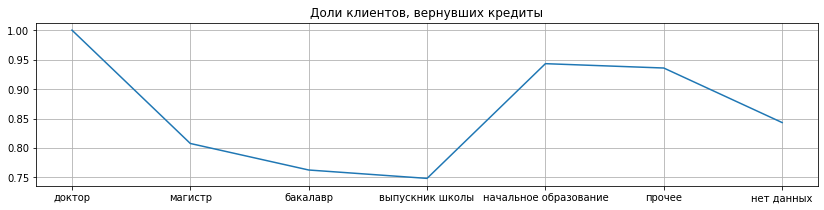

In [35]:
plt.figure(figsize = (14, 3))
plt.title('Доли клиентов, вернувших кредиты')
plt.plot(edu.loc[0])
plt.grid()

In [36]:
chi2, pval, dof, ex = stats.chi2_contingency(table.values)
print("p-value: ", pval)

p-value:  1.2332626245415605e-32


Нулевая гипотеза о равенстве распределений на уровне значимости 0.05 отвергается в пользу альтернативной. Образование влияет на возврат кредита. В то же время группы, имеющие самый высокий коэффициент возврата составляют незначительную часть от общего размера выборки

# Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [37]:
table = data.pivot_table(index = 'default', values = 'LIMIT_BAL', columns = 'MARRIAGE', 
                        aggfunc = len, fill_value = 0)

In [38]:
table.columns = ["отказываюсь отвечать", "замужем/женат", "холост", "нет данных"]

In [39]:
table

,отказываюсь отвечать,замужем/женат,холост,нет данных
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


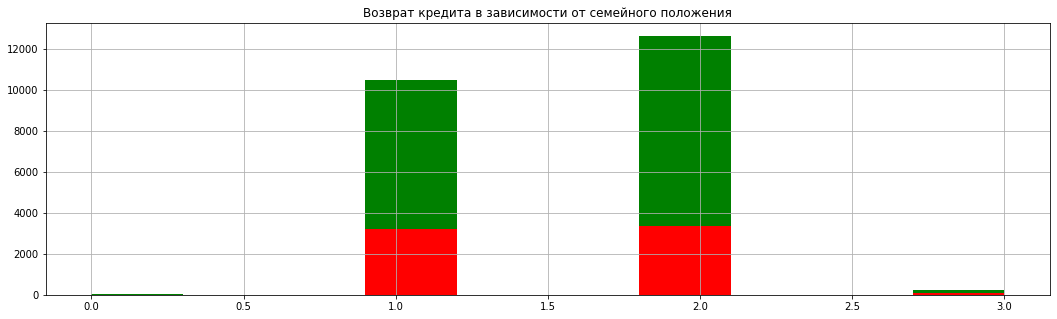

In [40]:
plt.figure(figsize = (18, 5))
plt.title("Возврат кредита в зависимости от семейного положения")
plt.hist(x = no_default['MARRIAGE'].values, color = 'green')
plt.hist(x = default['MARRIAGE'].values, color = 'red')
plt.grid()
plt.show()

In [41]:
chi2, pval, dof, ex = stats.chi2_contingency(table.values)
n = table.sum(axis = 0).sum()
cr_v = (chi2 / n) ** 0.5
print("Коэффициент V-Крамера:", cr_v)

Коэффициент V-Крамера: 0.034478203662766466


На уровне значимости 0.05 нулевая гипотеза о равенстве распределений отвергается, семейное положение не сильно влияет на возврат кредита

# Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [42]:
no_default.AGE.median()

34.0

In [43]:
default.AGE.median()

34.0

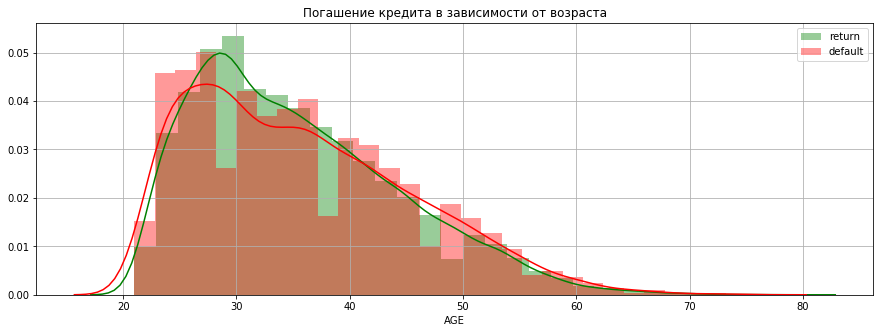

In [44]:
plt.figure(figsize = (15, 5))
sns.distplot(no_default['AGE'], color = 'green',  bins = 30, label = 'return')
sns.distplot(default['AGE'], color = 'red',  bins = 30, label = 'default')
plt.title('Погашение кредита в зависимости от возрастa')
plt.grid()
plt.legend()
plt.show()

In [45]:
no_def_med = np.median(bootstrap(no_default.AGE.values, 1000), axis = 1)
print("95% confidence interval (default = 0)", percentile(no_def_med))
def_med = np.median(bootstrap(default.AGE.values, 1000), axis = 1)
print("95% confidence interval (default = 1)", percentile(def_med))

95% confidence interval (default = 0) [34. 34.]
95% confidence interval (default = 1) [34. 35.]


In [46]:
diff_med = [x[0] - x[1] for x in zip(no_def_med, def_med)]
print("95% confidence interval difference median", percentile(diff_med))

95% confidence interval difference median [-1.  0.]


In [47]:
print ('Уровень значимости критерия Манна-Уитни:',
       mw(no_default.AGE.values, default.AGE.values, alternative = 'two-sided')[1])

Уровень значимости критерия Манна-Уитни: 0.3725035434898616


На уровне значимости 0.05 нулевая гипотеза о равенстве распределений не отвергается